Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [2]:
passenger_counts = df['Passengers'].values.astype('float32')
passenger_counts[:5]

array([112., 118., 132., 129., 121.], dtype=float32)

Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [3]:
split_point = int(len(passenger_counts) * 0.67)
train, test = passenger_counts[:split_point], passenger_counts[split_point:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 96, Test size: 48


# Висновки
- Для того аби розбити часовий ряд та тренування та тест, необхідно визначити точку часу яка і послугує розділюючим орієнтиром.
- Виміряємо довжину часового ряду та від нього визначимо точку яка відповідає 67%. Все що буде йти ДО цієї точки віднесемо до тренувального сету, значення ПІСЛЯ точки визначимо як тест

**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [4]:
import torch

def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + 1 : i + 1 + lookback])
   
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [5]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback) 
X_test, y_test = create_dataset(test, lookback=lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


# Висновки
- Результати роботи ф-цій співпадають з очікуваними результатами. Отже дані правильно розбиваються на тензори

Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class AirModel (nn.Module):
    def __init__ (self, hidden_size, num_layers):
        super(AirModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=1, 
                            hidden_size = hidden_size, 
                            num_layers = num_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out) 
        return out   

In [7]:
HIDDEN_SIZE = 50
NUM_LAYERS = 1

model = AirModel(hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
print(model)

model(torch.tensor([[112.]]))

AirModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


tensor([[0.0496]], grad_fn=<AddmmBackward0>)

# Висновки
- Для input size визначимо що він дорівнює = 1. Також наша ціль це задача передбачення на одне значення вперед тому вихід мережі теж має бути одним значенням -> nn.Linear(hidden size, 1)
- Модель успішно повернула значення для визначеного тензора. 

**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [39]:
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 8

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataloader first batch preview: {next(iter(train_loader))}")       

Train dataloader first batch preview: [tensor([[162.],
        [141.],
        [145.],
        [315.],
        [229.],
        [184.],
        [293.],
        [243.]]), tensor([[146.],
        [135.],
        [150.],
        [364.],
        [203.],
        [162.],
        [259.],
        [264.]])]


**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [40]:
mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
def train_model(model, train_loader, test_loader, optimizer, mse, num_epochs):
    """
    Train the model and print the train and test loss every 100 epochs.
    """

    total_train_loss = []
    total_rmse_train = []
    total_rmse_test = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for X_batch, y_batch in train_loader:
            model.train()
            optimizer.zero_grad()

            y_pred = model(X_batch)
            loss = mse(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        total_train_loss.append(epoch_loss / len(train_loader))

        
        model.eval()
        if epoch % 100 == 0:
             
            with torch.no_grad():

                train_rmse = model(X_train)
                test_rmse = model(X_test)
                
                train_rmse = torch.sqrt(mse(train_rmse, y_train)).item()
                test_rmse = torch.sqrt(mse(test_rmse, y_test)).item()
                total_rmse_train.append(train_rmse)
                total_rmse_test.append(test_rmse)

                print(f"Epoch {epoch}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return total_train_loss, total_rmse_train, total_rmse_test        


In [42]:
NUM_EPOCHS = 2000

train_loss, rmse_train, rmse_test = train_model(model, train_loader, test_loader, optimizer, mse, num_epochs=NUM_EPOCHS)

Epoch 0, Train RMSE: 226.1571, Test RMSE: 422.5498
Epoch 100, Train RMSE: 173.1171, Test RMSE: 366.9833
Epoch 200, Train RMSE: 132.3939, Test RMSE: 322.1634
Epoch 300, Train RMSE: 100.9124, Test RMSE: 283.6522
Epoch 400, Train RMSE: 80.4159, Test RMSE: 251.7443
Epoch 500, Train RMSE: 60.5779, Test RMSE: 222.8580
Epoch 600, Train RMSE: 45.4059, Test RMSE: 192.1443
Epoch 700, Train RMSE: 36.3964, Test RMSE: 167.5097
Epoch 800, Train RMSE: 30.3514, Test RMSE: 147.1103
Epoch 900, Train RMSE: 26.9494, Test RMSE: 131.4080
Epoch 1000, Train RMSE: 24.7090, Test RMSE: 118.1209
Epoch 1100, Train RMSE: 24.1738, Test RMSE: 112.9845
Epoch 1200, Train RMSE: 23.5814, Test RMSE: 105.4920
Epoch 1300, Train RMSE: 23.8191, Test RMSE: 98.3337
Epoch 1400, Train RMSE: 22.9888, Test RMSE: 92.1476
Epoch 1500, Train RMSE: 22.6382, Test RMSE: 90.3605
Epoch 1600, Train RMSE: 23.0943, Test RMSE: 88.8618
Epoch 1700, Train RMSE: 23.1788, Test RMSE: 86.9883
Epoch 1800, Train RMSE: 23.0575, Test RMSE: 87.3959
Epoch 1

# Висновки
- Зробимо аби під час навчання поверталися значення функції втрат на кожній епосі (як середнє значення по всім батчам), а також значення RMSE тля теста та тренування на кожній 100тій епосі для наочного порівняння роботи мережі.
- Можемо бачити, що мережа гарно навчилася на нам вдалося значно зменшити втрати в порівнянні з початком навчання, але все ще залишається велика розбіжність між тренувальною та тестовою метриками. 

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

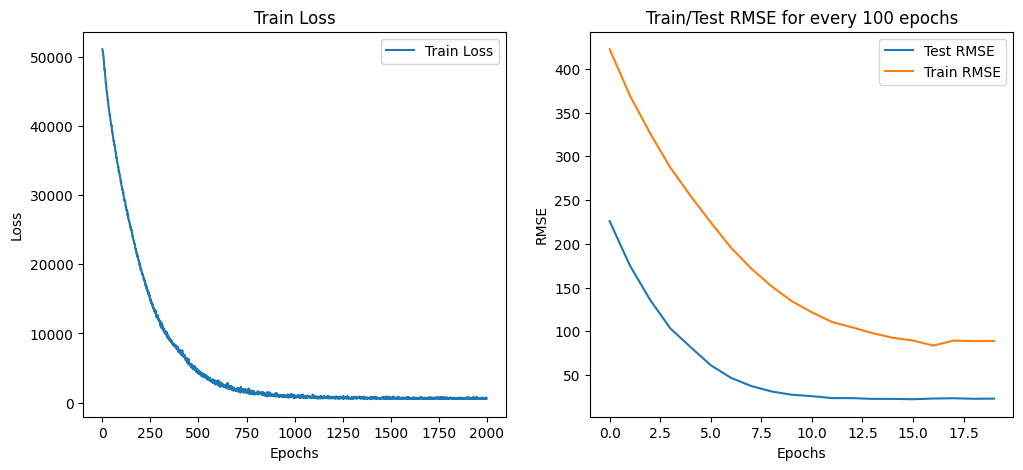

In [12]:
import matplotlib.pyplot as plt 

def plot_loss(train_loss, rmse_train, rmse_test):
    """
    Plot the train loss and test RMSE.
    """
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(rmse_train, label='Test RMSE')
    plt.plot(rmse_test, label='Train RMSE')
    plt.title('Train/Test RMSE for every 100 epochs')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

plot_loss(train_loss, rmse_train, rmse_test)


# Висновки
- По графіку видно що модель навчилася та вийшла на плато. 
- Також тестова та тренувальна метрики поводять себе схожим чином і обидві спадають, перенавчання не спостерігається. Але при тому значення метрики все ще залишаються доволі високими, особливо для тестового набору. Виглядає що ми досягли оптимального значення точності за даних параметрів мережі

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

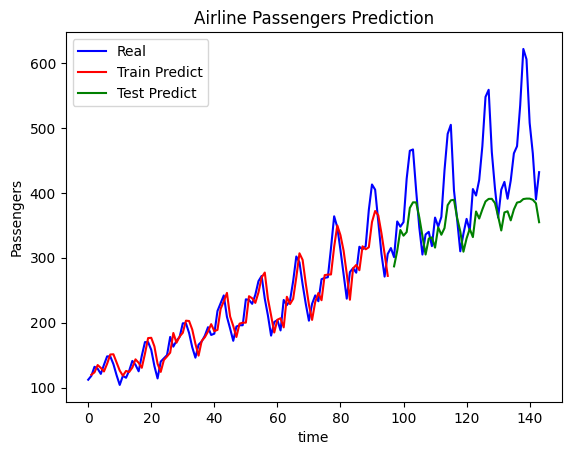

In [44]:
def plot_predicts(model):
  with torch.no_grad():
      train_size = len(train)
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(passenger_counts) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(passenger_counts) * np.nan
      test_plot[train_size+lookback:len(passenger_counts)] = model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(passenger_counts, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.title('Airline Passengers Prediction')
  plt.xlabel('time')
  plt.ylabel('Passengers')
  plt.legend(['Real', 'Train Predict', 'Test Predict'])
  plt.show()

plot_predicts(model)

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

Epoch 0, Train RMSE: 225.4555, Test RMSE: 421.8386
Epoch 100, Train RMSE: 127.6365, Test RMSE: 316.6771
Epoch 200, Train RMSE: 80.0907, Test RMSE: 250.9302
Epoch 300, Train RMSE: 49.3423, Test RMSE: 201.3054
Epoch 400, Train RMSE: 36.5924, Test RMSE: 169.3006
Epoch 500, Train RMSE: 28.6435, Test RMSE: 139.7511
Epoch 600, Train RMSE: 25.5305, Test RMSE: 118.3635
Epoch 700, Train RMSE: 23.4817, Test RMSE: 102.6856
Epoch 800, Train RMSE: 23.3521, Test RMSE: 98.1024
Epoch 900, Train RMSE: 22.8483, Test RMSE: 87.4238
Epoch 1000, Train RMSE: 22.5522, Test RMSE: 82.7221
Epoch 1100, Train RMSE: 22.5411, Test RMSE: 82.8350
Epoch 1200, Train RMSE: 22.5472, Test RMSE: 81.0544
Epoch 1300, Train RMSE: 22.6840, Test RMSE: 80.0044
Epoch 1400, Train RMSE: 22.5797, Test RMSE: 72.7546
Epoch 1500, Train RMSE: 22.3227, Test RMSE: 76.4039
Epoch 1600, Train RMSE: 22.4381, Test RMSE: 72.2459
Epoch 1700, Train RMSE: 23.2653, Test RMSE: 72.8117
Epoch 1800, Train RMSE: 22.8013, Test RMSE: 76.0268
Epoch 1900, Tr

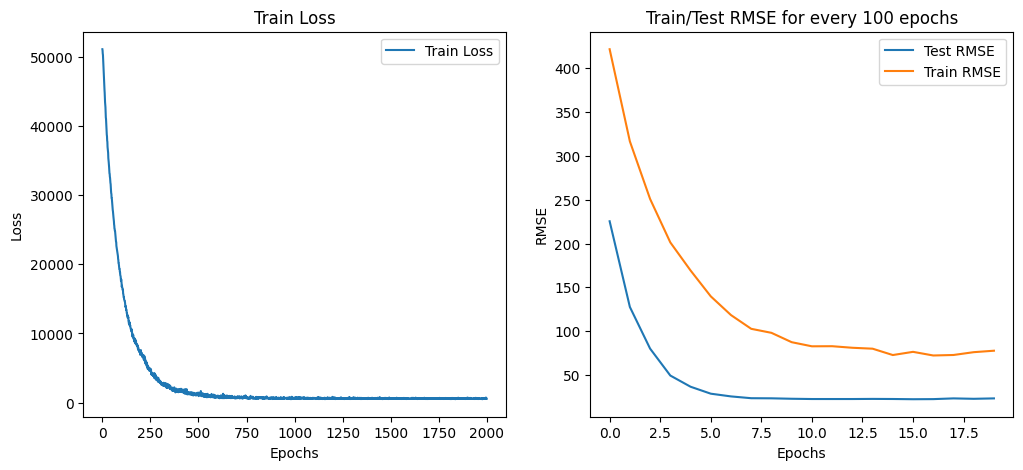

In [54]:
HIDDEN_SIZE = 100

model_2 = AirModel(hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
mse = nn.MSELoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

train_loss_2, rmse_train_2, rmse_test_2 = train_model(model_2, train_loader, test_loader, optimizer, mse, num_epochs=NUM_EPOCHS)

plot_loss(train_loss_2, rmse_train_2, rmse_test_2)


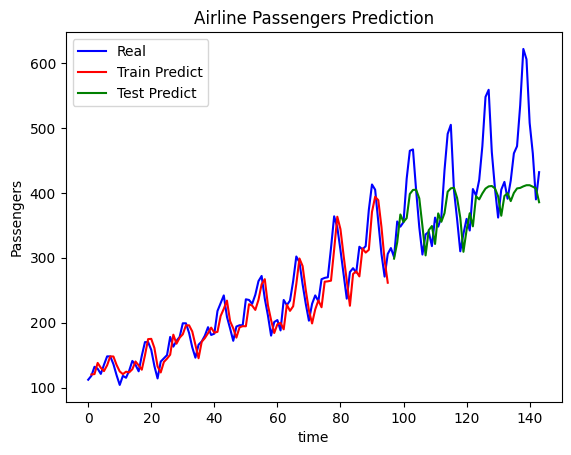

In [55]:
plot_predicts(model_2)

In [56]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

with torch.no_grad():
      train_size = len(train)
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(passenger_counts) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(passenger_counts) * np.nan
      test_plot[train_size+lookback:len(passenger_counts)] = model(X_test)[:, -1]

      train_plot_100 = np.ones_like(passenger_counts) * np.nan
      y_pred_100 = model_2(X_train)
      y_pred_100 = y_pred_100[:, -1]
      train_plot_100[lookback:train_size] = model_2(X_train)[:, -1]
      test_plot_100 = np.ones_like(passenger_counts) * np.nan
      test_plot_100[train_size+lookback:len(passenger_counts)] = model_2(X_test)[:, -1]

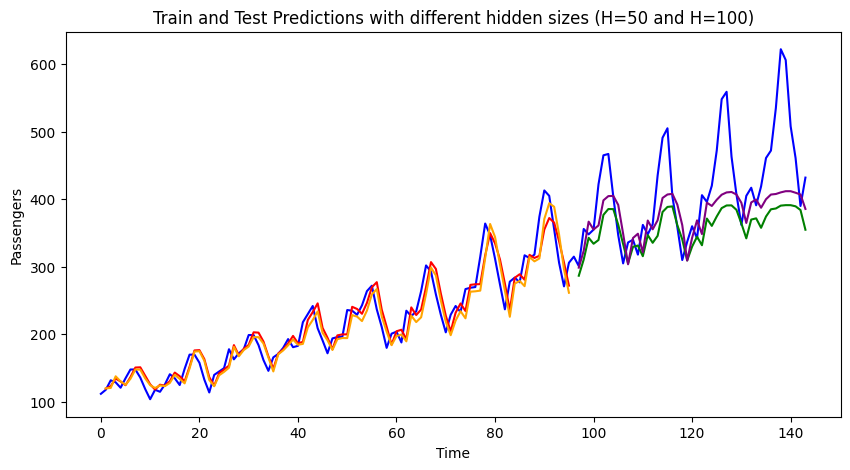

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(passenger_counts, c='b', label = "Real Data ") 

plt.plot(train_plot, c='r', label = "Train predict H=50")  
plt.plot(test_plot, c='g',label = "Test predict H=50") 

plt.plot(train_plot_100, c='orange', label = "Train predict H=100") 
plt.plot(test_plot_100, c='purple', label = "Test predict H=100")  
 
plt.title('Train and Test Predictions with different hidden sizes (H=50 and H=100)') 
plt.xlabel('Time')
plt.ylabel('Passengers')

plt.show()

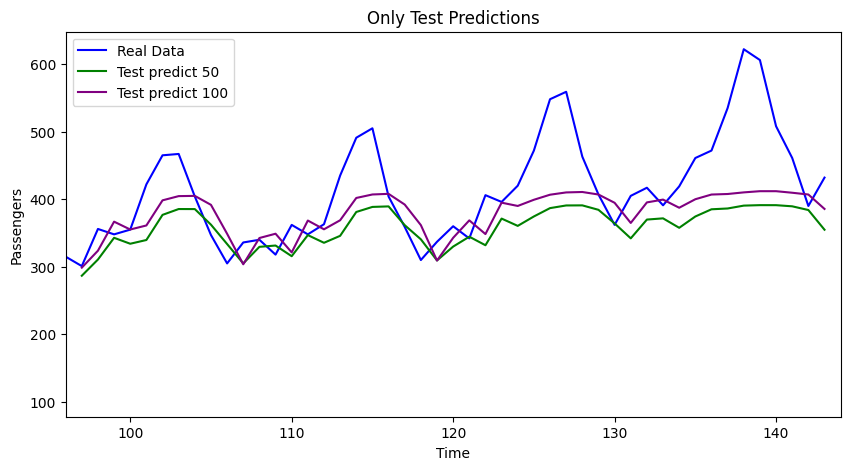

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(passenger_counts, c='b', label = "Real Data ") 
plt.plot(test_plot, c='g', label = "Test predict 50")   
plt.plot(test_plot_100, c='purple', label = "Test predict 100") 

plt.xlim(train_size, len(passenger_counts))
plt.title('Only Test Predictions')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.show()

# Висновки
- Створення більш складної мережі зі 100 шарами незначним чином поліпшило результати. Але в деяких випадках модель досі може помилятися на 100+ пасажирів, що є занадто великою похибкою для реального проекту. Особливо модель погано прогнозує пікові навантаження.
- Також при ускладненні моделі і залишенню тої самої к-ті епох, на останніх ітерація може спостерігатися можливе перенавчання моделі (тестова вибірки на Epoch 1700, RMSE = 72.8117 але після цього він починає зростати: 76.0268, 77.6896). Щоб переконатися в цьому дотренуємо модель ще на 2к епохах (можливо нам вдасться досягти кращих результатів). На основі коду нижче можна сказати що модель досягла свого піку навчання і подальші дії роблять її більш нестабільною (різкі коливання точності для тесту).
- Можливі удосконалення моделі: На поточному етапі ми використовували тільки 1 попереднє значення для прогнозу наступного, можливо цих значень недостатньо і необхідно робити передбачення з урахуванням більшої кількості минулих записів. Через те що в нас спостерігається річна сезонність ряду, то можливо доцільно взяти записи з останніх 12 місяців про прогнозу 

Epoch 0, Train RMSE: 22.5432, Test RMSE: 71.0104
Epoch 100, Train RMSE: 23.0310, Test RMSE: 72.9316
Epoch 200, Train RMSE: 23.5602, Test RMSE: 76.3805
Epoch 300, Train RMSE: 22.6672, Test RMSE: 68.2765
Epoch 400, Train RMSE: 22.4951, Test RMSE: 68.7058
Epoch 500, Train RMSE: 22.3751, Test RMSE: 71.6952
Epoch 600, Train RMSE: 22.3929, Test RMSE: 68.4524
Epoch 700, Train RMSE: 22.0141, Test RMSE: 69.0607
Epoch 800, Train RMSE: 22.9565, Test RMSE: 74.4174
Epoch 900, Train RMSE: 22.6837, Test RMSE: 66.8981
Epoch 1000, Train RMSE: 22.8537, Test RMSE: 70.8577
Epoch 1100, Train RMSE: 23.5752, Test RMSE: 73.5267
Epoch 1200, Train RMSE: 22.3519, Test RMSE: 67.9139
Epoch 1300, Train RMSE: 23.4042, Test RMSE: 79.0998
Epoch 1400, Train RMSE: 22.8576, Test RMSE: 75.0049
Epoch 1500, Train RMSE: 22.6227, Test RMSE: 69.4268
Epoch 1600, Train RMSE: 22.8353, Test RMSE: 71.9678
Epoch 1700, Train RMSE: 22.5324, Test RMSE: 65.3509
Epoch 1800, Train RMSE: 22.8781, Test RMSE: 74.3145
Epoch 1900, Train RMSE: 

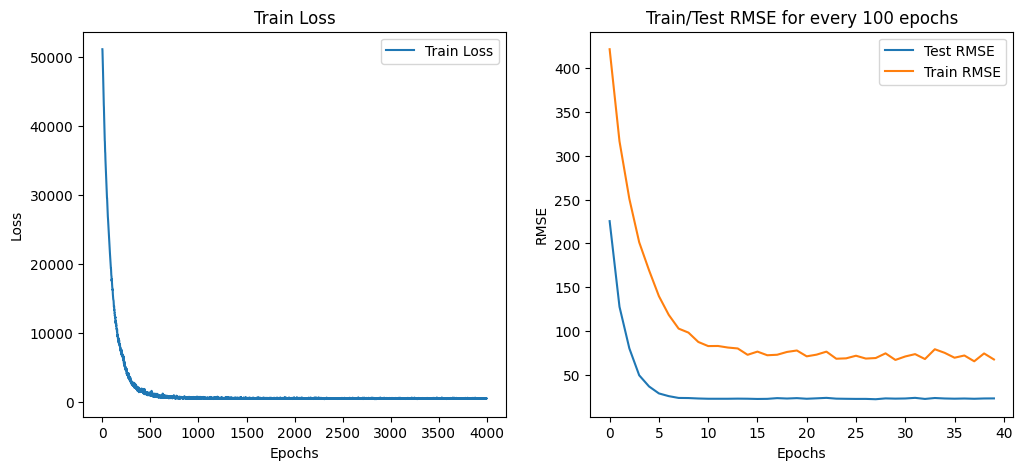

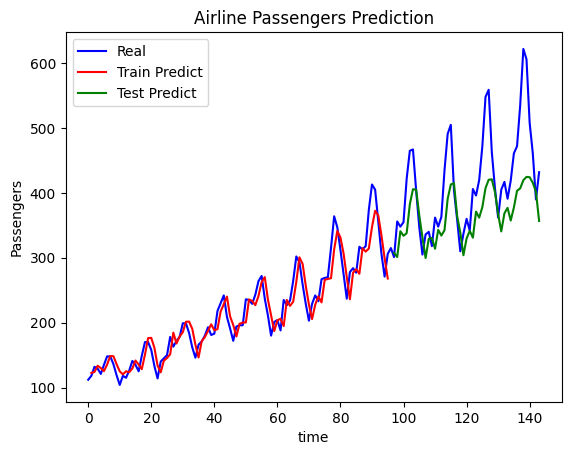

In [59]:
# extra experiment to train more epochs
train_loss_2_2, rmse_train_2_2, rmse_test_2_2 = train_model(model_2, train_loader, test_loader, optimizer, mse, num_epochs=2000)

merge_train_loss = train_loss_2 + train_loss_2_2
merge_rmse_train = rmse_train_2 + rmse_train_2_2
merge_rmse_test = rmse_test_2 + rmse_test_2_2

plot_loss(merge_train_loss, merge_rmse_train, merge_rmse_test)

plot_predicts(model_2)